# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

In [98]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy

from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [99]:
df = pd.read_csv('previsao_de_renda.csv')

### <span style="color:orange">Step 1: Preparing data | Splitting data</span>

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [101]:
df.drop_duplicates()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2016-03-01,16006,F,False,True,0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58
14996,14996,2016-03-01,3722,F,False,True,0,Pensionista,Superior completo,Solteiro,Casa,57,NaN,1.0,10093.45
14997,14997,2016-03-01,6194,F,True,True,0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82
14998,14998,2016-03-01,4922,M,True,False,0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27


In [102]:
df.isna().sum()

Unnamed: 0                  0
data_ref                    0
id_cliente                  0
sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            2573
qt_pessoas_residencia       0
renda                       0
dtype: int64

In [103]:
df_1 = df.dropna()

In [104]:
df_1.isna().sum()

Unnamed: 0               0
data_ref                 0
id_cliente               0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [105]:
y, X = patsy.dmatrices('np.log(renda) ~ C(sexo) + posse_de_veiculo + posse_de_imovel + qtd_filhos + C(tipo_renda) + C(educacao, Treatment(2)) + C(estado_civil) + C(tipo_residencia, Treatment(1)) + idade + tempo_emprego + qt_pessoas_residencia ', data = df_1)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

### <span style="color:orange">Step 2: Ridge regression</span>

In [107]:
# Ridge Regularization - I didn't make the function '.fit_regularized, L1_wt = 0' as proposal. I got the Ridge function from sci"
clfs = []
ridge_id = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]

for i in range(8):
    clf = Ridge(alpha=ridge_id[i])
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [108]:
mse_scores_ridge  = [clf.score(X_test, y_test) for clf in clfs]

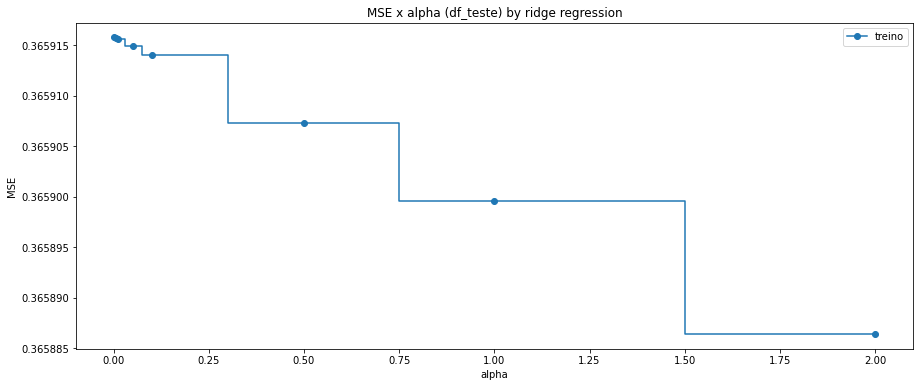

In [109]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha (df_teste) by ridge regression")
ax.plot(ridge_id, mse_scores_ridge, marker='o', label="treino",
        drawstyle="steps-mid")
ax.legend()
plt.show()

<span style="color:blue">**Ridge regression:** As variações no MSE pelo alpha do ridge são mínimas. Incluí mais três valores para tentar perceber um gap maior e a variação no MSE continua bem pequena, mas com tendência de diminuir conforme aumenta o alpha.</span>

### <span style="color:orange">Step 3: Lasso regression</span>

In [110]:
# Lasso Regularization
clfs2 = []
lasso_id = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2]

for i in range(8):
    clf2 = Lasso(alpha=lasso_id[i])
    clf2.fit(X_train, y_train)
    clfs2.append(clf2)

In [111]:
mse_scores_lasso  = [clf2.score(X_test, y_test) for clf2 in clfs2]

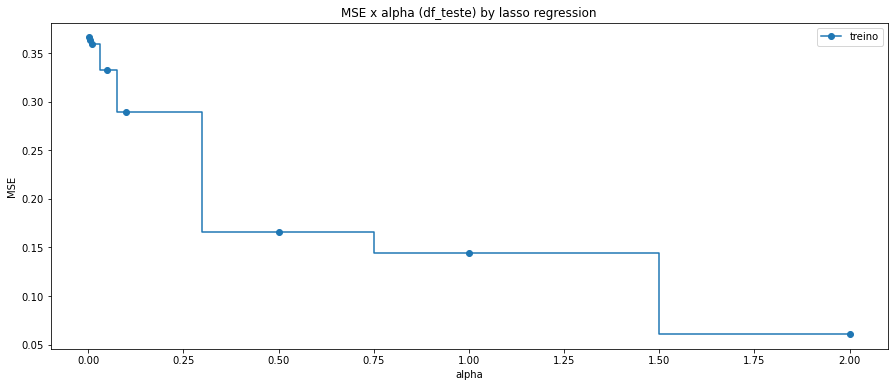

In [112]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha (df_teste) by lasso regression")
ax.plot(lasso_id, mse_scores_lasso, marker='o', label="treino",
        drawstyle="steps-mid")
ax.legend()
plt.show()

<span style="color:blue">**Lasso regression:** As variações no MSE pela regressão lasso mostram um gap bem mais amplo ao longo da variação do alpha. O MSE cai dramaticamente ao aumento do alpha. O ridge parece mostrar um melhor resultado.</span>

<span style="color:blue">**Obs:** Não consegui usar o código proposto na aula. Não entendi como aplicar só a base teste no código. Aguardo as orientações. Assim, segui com os métodos Ridge e Lasso do sklearn.</span>

### <span style="color:orange">Step 4 | 5 | 6: Stepwise regression</span>

<span style="color:blue">**Não executado** Não consegui desenvolver esse item. Já estou preso nele há vários meses e não consigo fazer esse código abordado na aula funcionar para a base teste. Já estou muito atrasado no curso, vou avançar sem isso pendente. Aguardo orientações. Obrigado.</span>

In [113]:
model = sm.OLS(y_test, X_test).fit()

In [114]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     76.72
Date:                Sun, 19 Feb 2023   Prob (F-statistic):          2.05e-291
Time:                        19:28:42   Log-Likelihood:                -3354.1
No. Observations:                3107   AIC:                             6758.
Df Residuals:                    3082   BIC:                             6909.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
var_0          5.9897      1.017      5.889      0.000       3.996       7.984
var_1          0.7808      0.029     26.809      0.000       0.724       0.838
var_2          0.0770      0.028      2.751      0.006       0.022       0.132
var_3          0.1049      0.028      3.731      0.000       0.050       0.160
var_4          0.2621      0.322      0.815      0.415      -0.369       0.893
var_5          0.1712      0.030      5.777      0.000       0.113       0.229
var_6         -0.3711      0.717     -0.517      0.605      -1.777       1.035
var_7          0.0844      0.044      1.915      0.056      -0.002       0.171
var_8          0.0925      0.154      0.600      0.548      -0.210       0.395
var_9         -0.3511      0.359     -0.978      0.328      -1.055       0.353
var_10         0.1350      0.027      4.912      0.000       0.081       0.189
var_11        -0.2026      0.067     -3.008      0.003      -0.335      -0.071
var_12         0.5105      0.511      0.999      0.318      -0.491       1.512
var_13         0.5442      0.506      1.075      0.282      -0.448       1.537
var_14        -0.0993      0.051     -1.938      0.053      -0.200       0.001
var_15         0.6037      0.514      1.175      0.240      -0.404       1.611
var_16        -0.0660      0.106     -0.623      0.534      -0.274       0.142
var_17         0.0008      0.060      0.013      0.990      -0.117       0.118
var_18        -0.2096      0.170     -1.230      0.219      -0.544       0.125
var_19         0.0809      0.147      0.549      0.583      -0.208       0.370
var_20         0.0159      0.077      0.205      0.837      -0.136       0.167
var_21        -0.4784      0.508     -0.941      0.347      -1.475       0.519
var_22         0.0055      0.002      3.383      0.001       0.002       0.009
var_23         0.0615      0.002     29.452      0.000       0.057       0.066
var_24         0.5365      0.508      1.057      0.291      -0.459       1.532
==============================================================================
Omnibus:                        0.928   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.923
Skew:                           0.042   Prob(JB):                        0.630
Kurtosis:                       2.998   Cond. No.                     5.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <span style="color:orange">Step 7: Regression tree</span>

In [145]:
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X_test, y_test);

In [146]:
mse = regr.score(X_test, y_test)
print(mse)

0.3584987439465941


<span style="color:blue">**MSE** Com uma árvore em profundidade 3 chegamos num MSE menor do que o LASSO.</span>

In [147]:
path = regr.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00390752, 0.01426326, 0.01801349, 0.01994045,
        0.05918923, 0.06262379, 0.1024636 ]),
 'impurities': array([0.52815826, 0.53206578, 0.54632903, 0.56434252, 0.58428297,
        0.6434722 , 0.706096  , 0.8085596 ])}

Text(0, 0.5, 'Impureza total das folhas')

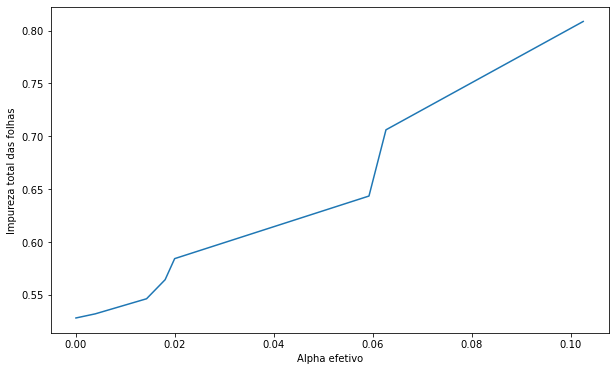

In [149]:
# alpha x impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("Alpha efetivo")
plt.ylabel("Impureza total das folhas")

In [150]:
# tree x alpha
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_test, y_test)
    clfs.append(clf)

In [151]:
test_scores  = [mean_squared_error(y_test  , clf.predict(X_test )) for clf in clfs]

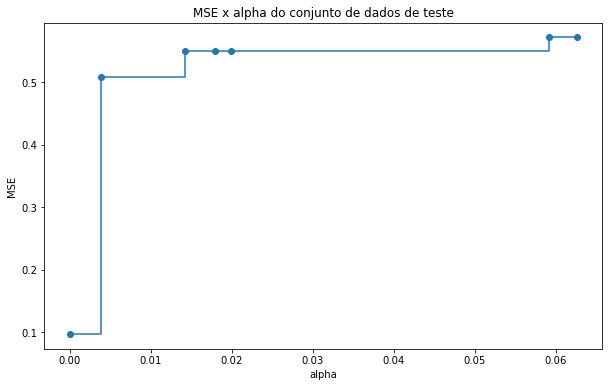

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("alpha")
ax.set_ylabel("MSE")
ax.set_title("MSE x alpha do conjunto de dados de teste")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker='o', label="teste",
        drawstyle="steps-post")

plt.show()